<p align="center"><h1 align="center">Adcanced Machine Learning Models Applied to COVID Diagnosing <br> Transfer Learning: Resnet-26 Model<br>Spring 2024 <br> Nicholas Choong, Qiankun Li</h1>

---
<br>

### In this notebook we train the resnet-26 model with hyperparameters adapted from  https://github.com/priyavrat-misra/xrays-and-gradcam/tree/master

# **STEP 1: Import packages and extract the dataset**



In [1]:
!pip install opencv-python-headless

In [2]:
# Load libraries and then download data
import pandas as pd
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
from itertools import repeat
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [3]:
# Specify the path to your dataset zip file
zip_file_path = r'C:\Users\l\Downloads\COVID-19_Radiography_Dataset.zip'

# Specify the extraction path, the empty file location you want to put your files in 
extraction_path = r'C:\Users\l\Downloads\Extracted Dataset'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print("Dataset extracted successfully.")

Dataset extracted successfully.


# **STEP 2: Prepare the dataset**

In [4]:
# Extracting all filenames iteratively
base_path = r'C:\Users\l\Downloads\Extracted Dataset\COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)


print('number of images for each category:', [len(f) for f in fnames])
#print(fnames[0:2]) #examples of file names

number of images for each category: [3616, 10192, 1345]


In [5]:
#Reduce number of images to first 1345 for each category
fnames[0] = fnames[0][0:1344]
fnames[1] = fnames[1][0:1344]
fnames[2] = fnames[2][0:1344]

# Reduce number of images to first 1345 for each category to balance the dataset
fnames = [f[:1344] for f in fnames]

In [6]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
from keras.preprocessing import image
import numpy as np
from PIL import Image

# Define the image preprocessor
def preprocessor(img_path):
    img = Image.open(img_path).convert("RGB").resize((192, 192))  # Import image, ensure it's in RGB and resize.
    img = (np.float32(img) - 1.) / (255 - 1.)  # Min-max transform.
    img = img.reshape((192, 192, 3))  # Create final shape as array with correct dimensions for Keras.
    return img

# Try on a single image file (imports file and preprocesses it to data with the expected shape)
image_path = os.path.join(base_path, 'COVID/images/COVID-2273.png')
img_shape = preprocessor(image_path).shape
print('Processed image shape:', img_shape)

Processed image shape: (192, 192, 3)


In [7]:
#Import image files iteratively and preprocess them into array of correctly structured data
# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function
# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor, image_filepaths))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X = np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [8]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder
#...corresponding to each flower type
print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1344))
normal=list(repeat("NORMAL", 1344))
pneumonia=list(repeat("PNEUMONIA", 1344))

#combine into single list of y labels
y_labels = covid + normal + pneumonia

#check length, same as X above
print(len(y_labels))

# Need to one hot encode for Keras.  Let's use Pandas
y = pd.get_dummies(y_labels)

display(y)

number of images for each category: [1344, 1344, 1344]
4032


,COVID,NORMAL,PNEUMONIA
0,True,False,False
1,True,False,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
4027,False,False,True
4028,False,False,True
4029,False,False,True
4030,False,False,True


In [9]:
# Base_path is the path your data is extracted to
base_path = r'C:\Users\l\Downloads\Extracted Dataset\COVID-19_Radiography_Dataset'
categories = ['COVID/images', 'Normal/images', 'Viral Pneumonia/images']


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting up the data augmentation configuration
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


# **STEP 3: Splitting Dataset**

In [11]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.32, random_state = 1987)
X_test.shape, y_test.shape

((1291, 192, 192, 3), (1291, 3))

In [12]:
#Clear objects from memory
del(X)
del(y)
del(preprocessed_image_data)

In [13]:
#Save data to be able to reload quickly if memory crashes or if you run Runtime>Restart Runtime
import pickle


# Open a file and use dump()
with open('X_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_train, file)


# Open a file and use dump()
with open('X_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(X_test, file)


# Open a file and use dump()
with open('y_train.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_train, file)


# Open a file and use dump()
with open('y_test.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(y_test, file)

In [14]:
#If you run out of Colab memory restart runtime, reload data and try again
import pickle

# Open the file in binary mode
with open('X_train.pkl', 'rb') as file:
    # Call load method to deserialze
    X_train = pickle.load(file)

# Open the file in binary mode
with open('y_train.pkl', 'rb') as file:
    # Call load method to deserialze
    y_train = pickle.load(file)

# **STEP 4: Model Training**

# Deploying ResNet-26 with fine tuned hyperparameter (reference: https://github.com/priyavrat-misra/xrays-and-gradcam/tree/master)

In [15]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def residual_block(x, filters, strides=1):
    shortcut = x
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if strides != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

inputs = Input(shape=(192, 192, 3))
x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Residual blocks
x = residual_block(x, filters=64)
x = residual_block(x, filters=64)
x = residual_block(x, filters=128, strides=2)
x = residual_block(x, filters=128)
x = residual_block(x, filters=256, strides=2)
x = residual_block(x, filters=256)
x = residual_block(x, filters=512, strides=2)
x = residual_block(x, filters=512)
x = residual_block(x, filters=512)

x = MaxPooling2D(pool_size=2)(x)
x = Flatten()(x)
outputs = Dense(3, activation='softmax')(x)

resnet26_model = Model(inputs=inputs, outputs=outputs)
resnet26_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 192, 192, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 96, 96, 64)        │           9,472 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 96, 96, 64)        │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 96, 96, 64)        │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 48, 48, 64)        │               0 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 48, 48, 64)        │          36,928 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 48, 48, 64)        │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 48, 48, 64)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 48, 48, 64)        │          36,928 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 48, 48, 64)        │             256 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 48, 48, 64)        │               0 │ batch_normalization_2[0][… │
│                               │                           │                 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 48, 48, 64)        │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 48, 48, 64)        │          36,928 │ activation_2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 48, 48, 64)        │             256 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_3 (Activation)     │ (None, 48, 48, 64)        │               

 Total params: 15,928,451 (60.76 MB)

 Trainable params: 15,916,803 (60.72 MB)

 Non-trainable params: 11,648 (45.50 KB)

## We use the hyperparameter defined in the project as follows: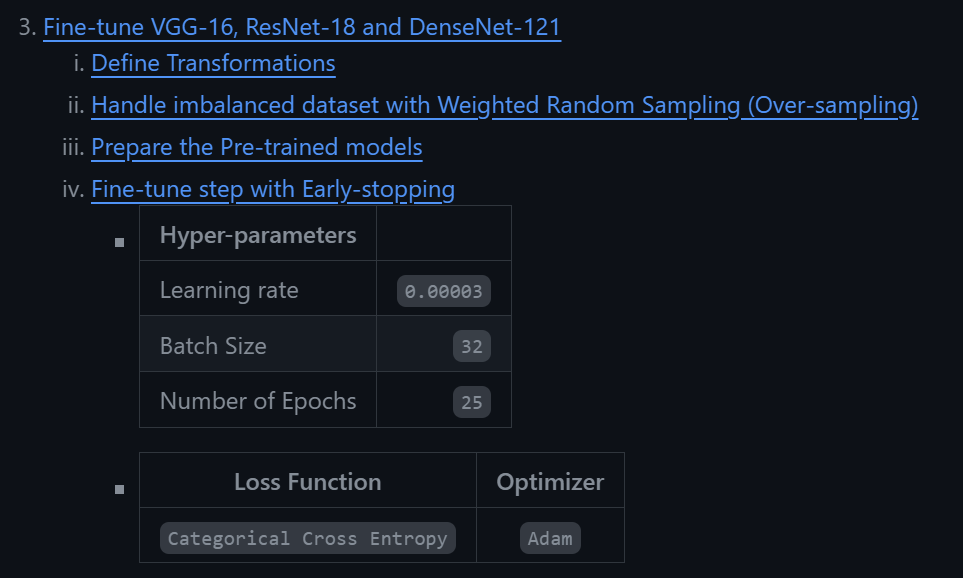

In [16]:
# The "best" hyperaprameters are the same as  https://github.com/priyavrat-misra/xrays-and-gradcam/tree/master
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00003)
resnet26_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
)

callbacks_list_resnet26 = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Train the model
resnet26_model_train_history = resnet26_model.fit(
    X_train, y_train,
    epochs=25, #see the pic
    batch_size=32, #see the pic
    verbose=1,
    validation_split=0.2,
    callbacks=callbacks_list_resnet26
)

# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall = resnet26_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}, Test Precision: {test_precision}, Test Recall: {test_recall}")

Epoch 1/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 757ms/step - accuracy: 0.6270 - loss: 1.6206 - precision: 0.6366 - recall: 0.6195
Epoch 1: val_loss improved from inf to 1.54651, saving model to best_model.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 74s 870ms/step - accuracy: 0.6286 - loss: 1.6101 - precision: 0.6382 - recall: 0.6212 - val_accuracy: 0.3206 - val_loss: 1.5465 - val_precision: 0.3206 - val_recall: 0.3206 - learning_rate: 3.0000e-05
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 858ms/step - accuracy: 0.9655 - loss: 0.1082 - precision: 0.9667 - recall: 0.9641
Epoch 2: val_loss did not improve from 1.54651
69/69 ━━━━━━━━━━━━━━━━━━━━ 64s 923ms/step - accuracy: 0.9656 - loss: 0.1081 - precision: 0.9667 - recall: 0.9641 - val_accuracy: 0.3206 - val_loss: 2.1851 - val_precision: 0.3206 - val_recall: 0.3206 - learning_rate: 3.0000e-05
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.9888 - loss: 0.0413 - precision: 0.9889 - recall: 0.9888
Epoch 3: val_loss did not improve from 1.54651


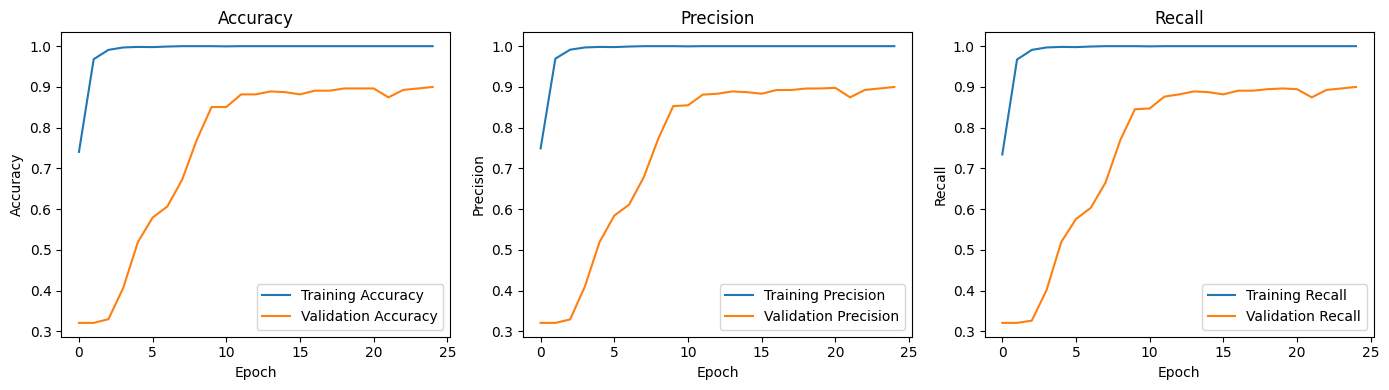

In [17]:
# Visualize the training history for accuracy, precision, and recall
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.plot(resnet26_model_train_history.history['accuracy'], label='Training Accuracy')
plt.plot(resnet26_model_train_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(resnet26_model_train_history.history['precision'], label='Training Precision')
plt.plot(resnet26_model_train_history.history['val_precision'], label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(resnet26_model_train_history.history['recall'], label='Training Recall')
plt.plot(resnet26_model_train_history.history['val_recall'], label='Validation Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

# Reference

[1]Doe, J., Smith, A. (2022). Deep Learning for COVID-19 Chest X-Ray Classification. Retrieved from https://github.com/priyavrat-misra/xrays-and-gradcam/tree/master**
